# <p style="text-align: center;"> <a href='https://www.kaggle.com/c/digit-recognizer'>Kaggle competition: Digit Recognizer</a></p>

# Preparation

In [5]:
%matplotlib inline
import logging
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt

logger = logging.getLogger()
logger.setLevel(logging.INFO)

train_data = pd.read_csv('./train.csv').sample(frac=1)
submission_test_data = pd.read_csv('./test.csv')
pixel_columns = ['pixel' + str(i) for i in range(784)]

X_train, X_test, y_train, y_test = train_test_split(train_data[pixel_columns], train_data['label'], test_size=0.20, random_state=40)

# Create more images

In [11]:
import keras

ModuleNotFoundError: No module named 'keras'

## Train on 80% of data, Test on 20% of data

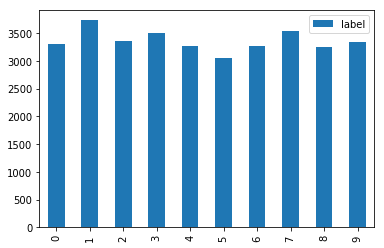

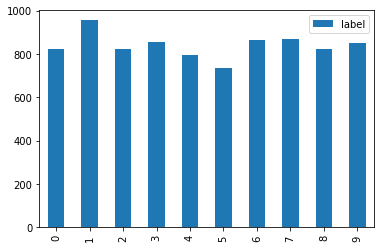

In [6]:
plots = y_train.value_counts().sort_index().to_frame().plot.bar(), y_test.value_counts().sort_index().to_frame().plot.bar()

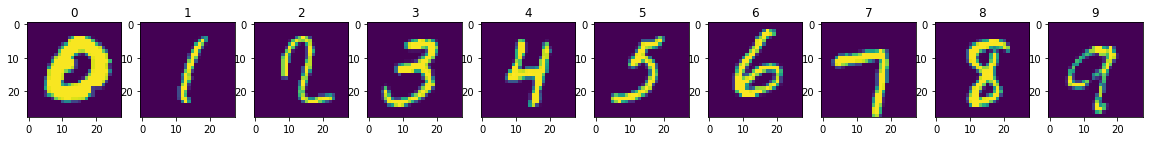

In [7]:
plt.figure(num='digit',figsize=(20, 5))
for idx, row in train_data.sample(frac=1).sort_values(by=['label']).drop_duplicates(subset=['label']).iterrows():
    image = np.array(row[pixel_columns]).reshape([-1,28,28,1])
    plt.subplot(1, 10, row['label'] + 1)
    plt.title(row['label'])
    plt.imshow(np.squeeze(image))

# With Logistic regression (SOFTMax)

In [10]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)

y_prediction = clf.predict(X_test)

precision_recall_fscore_support(y_test, y_prediction, average='macro'), precision_recall_fscore_support(y_test, y_prediction, average='micro')

((0.9113807241829772, 0.9110689702419782, 0.9111443656897782, None),
 (0.9127380952380952, 0.9127380952380952, 0.9127380952380952, None))

In [44]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_scaled = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [37]:
X_scaled

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# First try, using SVM

In [26]:
clf = svm.SVC(decision_function_shape='ovo', kernel='poly', degree=2)
logger.info("Training")
clf.fit(X_train, y_train)
logger.info("Predict")
y_prediction = clf.predict(X_test)
logger.info("Metrics") 
precision_recall_fscore_support(y_test, y_prediction, average='macro'), precision_recall_fscore_support(y_test, y_prediction, average='micro')

((0.9732387261209796, 0.9733204299580838, 0.9732597230452127, None),
 (0.973452380952381, 0.973452380952381, 0.973452380952381, None))

Polynomial SVC performs well : around 97% of precision and recall. Using a degree of 2 might be related with the fact that we are working with 2d images.

# Second try, K-Nearest neighbor

In [ ]:
from sklearn.neighbors import NearestNeighbors

# Third try, CNN